In [51]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [4]:
# Load the dataset
df = pd.read_excel('OnlineRetail.xlsx')

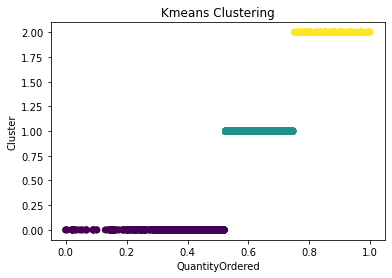

In [10]:


# Preprocess the data
df = df.dropna()  # Remove missing values
df = df[(np.abs(stats.zscore(df['Quantity'])) < 3)]  # Remove outliers

# Scale the data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[['Quantity']]), columns=['Quantity'])

# Perform Kmeans clustering
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(df_scaled)

# Visualize the clusters
plt.scatter(df_scaled['Quantity'], kmeans.labels_, c=kmeans.labels_, cmap='viridis')
plt.title('Kmeans Clustering')
plt.xlabel('QuantityOrdered')
plt.ylabel('Cluster')
plt.show()

In [18]:
df.shape

(401916, 8)

In [19]:
df.info

<bound method DataFrame.info of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  Cust

In [20]:
df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [21]:
df['CustomerID'] = df['CustomerID'].astype(str)

In [23]:
# New Attribute : Monetary

df['Amount'] = df['Quantity']*df['UnitPrice']
rfm_m = df.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12347.0,4060.40
1,12348.0,1195.08
2,12349.0,1757.55
3,12350.0,334.40
4,12352.0,1545.41


In [24]:
# New Attribute : Frequency

rfm_f = df.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12347.0,181
1,12348.0,20
2,12349.0,73
3,12350.0,17
4,12352.0,95


In [25]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12347.0,4060.40,181
1,12348.0,1195.08,20
2,12349.0,1757.55,73
3,12350.0,334.40,17
4,12352.0,1545.41,95


In [26]:
# New Attribute : Recency

# Convert to datetime to proper datatype

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [28]:
# Compute the maximum date to know the last transaction date

max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [29]:
# Compute the difference between max date and transaction date

df['Diff'] = max_date - df['InvoiceDate']
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [30]:
# Compute last transaction date to get the recency of customers

rfm_p = df.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12347.0,1 days 20:58:00
1,12348.0,74 days 23:37:00
2,12349.0,18 days 02:59:00
3,12350.0,309 days 20:49:00
4,12352.0,35 days 22:13:00


In [31]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12347.0,1
1,12348.0,74
2,12349.0,18
3,12350.0,309
4,12352.0,35


In [32]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12347.0,4060.40,181,1
1,12348.0,1195.08,20,74
2,12349.0,1757.55,73,18
3,12350.0,334.40,17,309
4,12352.0,1545.41,95,35


Text(0.5, 0, 'Attributes')

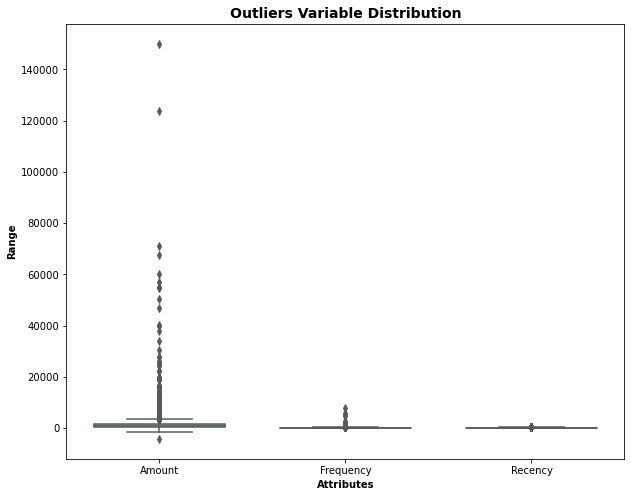

In [35]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [36]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [37]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4271, 3)

In [38]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,1.703014,1.042258,-0.906616
1,-0.015214,-0.578099,-0.183752
2,0.322079,-0.044690,-0.738278
3,-0.531332,-0.608292,2.143277
4,0.194866,0.176726,-0.569939


# Kmeans

In [39]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [40]:
kmeans.labels_

array([2, 0, 0, ..., 3, 0, 0])

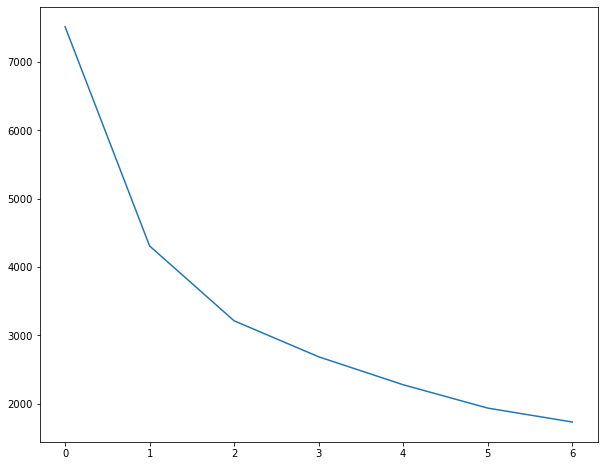

In [41]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

# Silhouette Analysis

In [42]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.5420560776970786
For n_clusters=3, the silhouette score is 0.509073190582349
For n_clusters=4, the silhouette score is 0.4829903239763363
For n_clusters=5, the silhouette score is 0.46786087059518217
For n_clusters=6, the silhouette score is 0.4203441495161719
For n_clusters=7, the silhouette score is 0.4168756963855804
For n_clusters=8, the silhouette score is 0.409842081819339


In [43]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [44]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12347.0,4060.40,181,1,1
1,12348.0,1195.08,20,74,2
2,12349.0,1757.55,73,18,2
3,12350.0,334.40,17,309,0
4,12352.0,1545.41,95,35,2


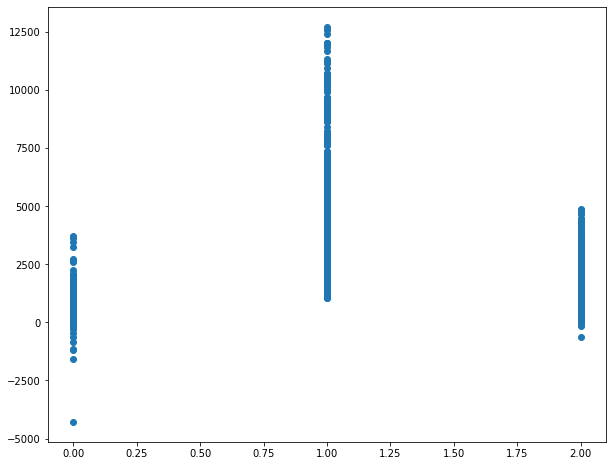

In [60]:
# Box plot to visualize Cluster Id vs Frequency

plt.scatter(x='Cluster_Id', y='Amount', data=rfm,cmap="rainbow")


<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

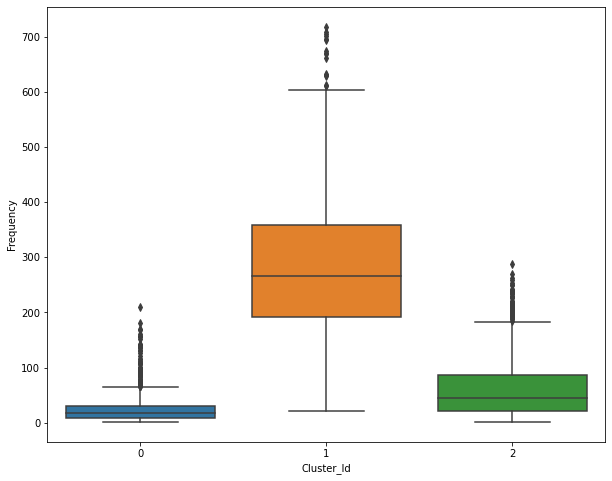

In [48]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

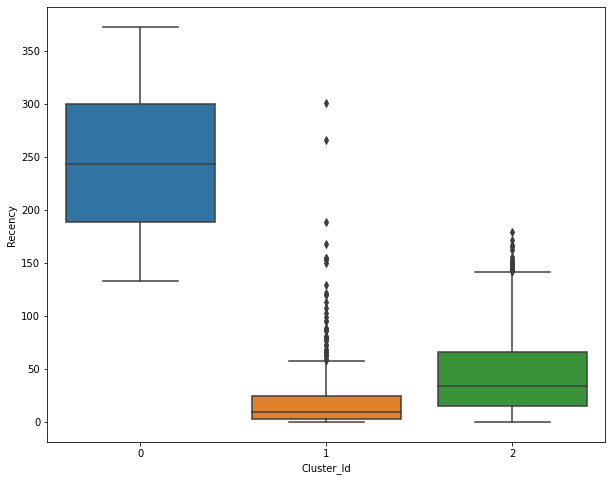

In [49]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

# Hierarchical Clustering

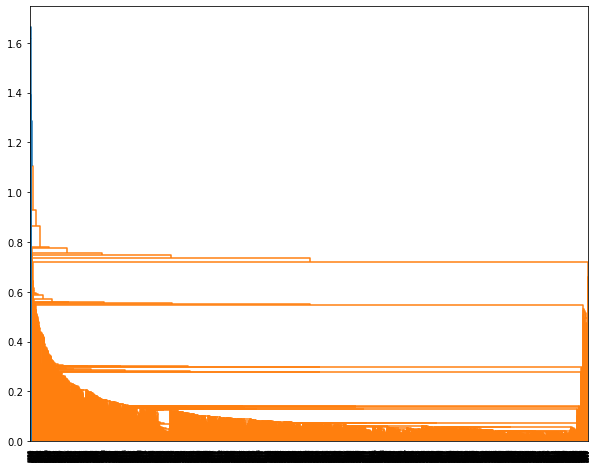

In [52]:
# Single linkage: 

mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

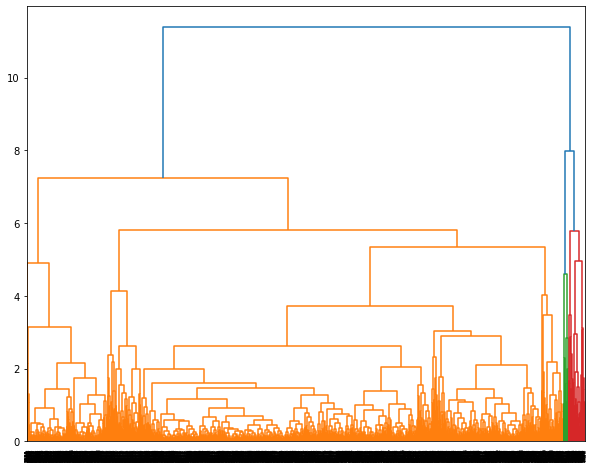

In [53]:
# Complete linkage

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

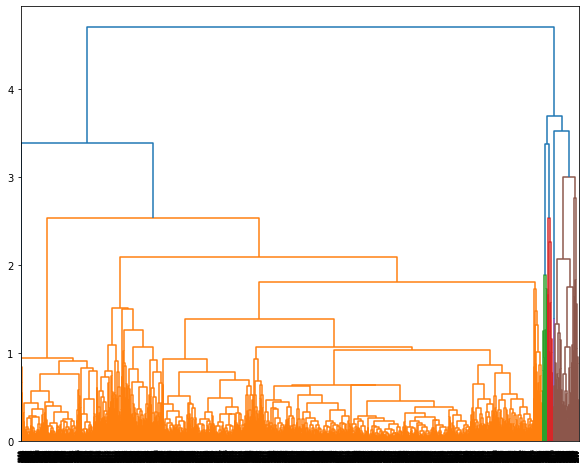

In [54]:
# Average linkage

mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

In [55]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [56]:
# Assign cluster labels

rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,12347.0,4060.40,181,1,1,0
1,12348.0,1195.08,20,74,2,0
2,12349.0,1757.55,73,18,2,0
3,12350.0,334.40,17,309,0,0
4,12352.0,1545.41,95,35,2,0


<AxesSubplot:xlabel='Cluster_Labels', ylabel='Amount'>

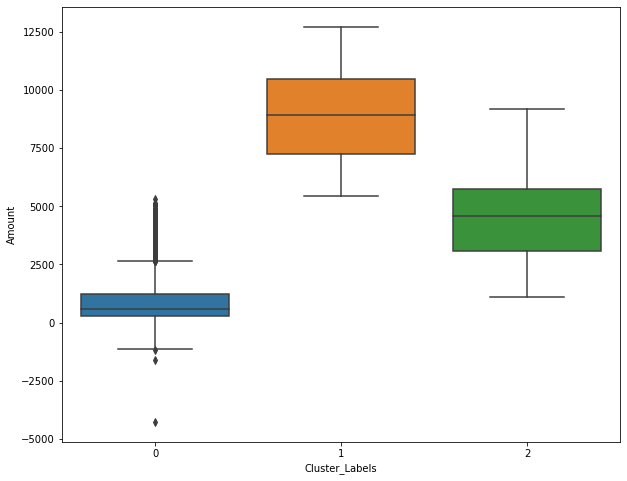

In [57]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

<AxesSubplot:xlabel='Cluster_Labels', ylabel='Frequency'>

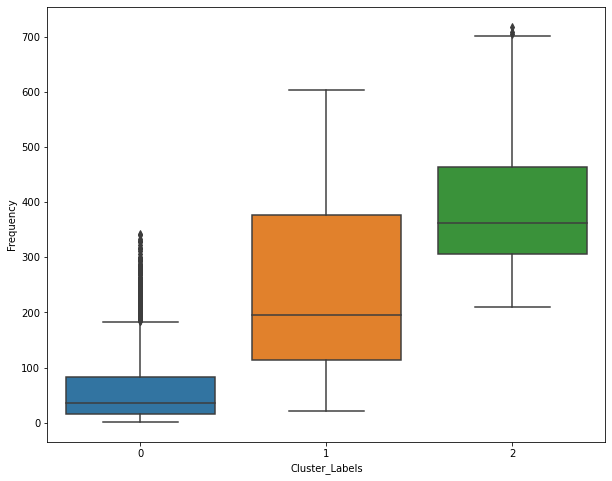

In [58]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

<AxesSubplot:xlabel='Cluster_Labels', ylabel='Recency'>

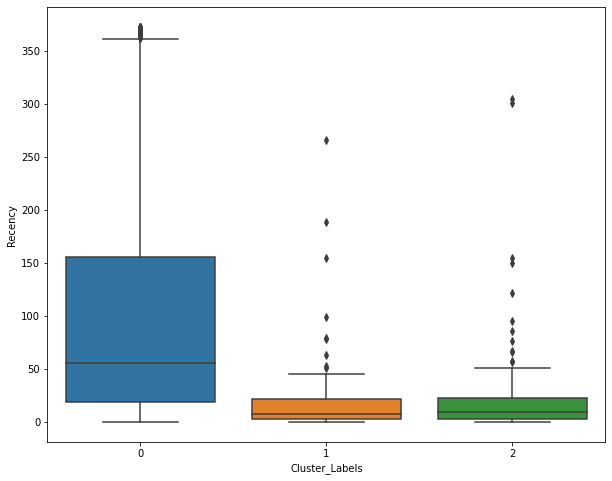

In [59]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

# Final Analysis